# Capstone Project Sandbox
To do:

- Create history object from a sim that has run to store data as callable attributes
- Viz in base-12
- districts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/Users/ssrosa/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [133]:
class Lot(object):
    def __init__(self):
        self.size = None
        self.zoned_as = [None]
        #Coords where lot is. Just for viz
        self.loc = []
        self.residences = [[]]
    def update(self):
        #Append last time step's residences
        self.zoned_as.append(self.zoned_as[-1])
        self.residences.append([r for r in self.residences[-1]])

class Developer(object):
    def __init__(self):
        self.residences_built = [[]]
        #100sqft - about a 9X12 room
        #Hard coded for now
        self.min_res_size = 100
    def build_on(self, lot):
        #Remaining empty land on this lot:
        avail_area = lot.size - sum([residence.size for residence in lot.residences[-1]])
        #If avail area exceeds min residence size that this developer can build
        if  avail_area > self.min_res_size:
            #Distribution of possible sizes for a new residence
            size_dist = np.arange(self.min_res_size, avail_area)
            #Initialize new residence object
            #Give residence a random size within the realm of possibility
            size = np.random.choice(size_dist)
            residence = Residence(size, lot.zoned_as[-1])
            #Add residence to last list of residences built on the lot
            lot.residences[-1].append(residence)
            #Add residence to last list of residence built by this developer
            self.residences_built[-1].append(residence)

class Residence(object):
    def __init__(self, size, zoned_as):
        self.size = size
        self.zoned_as = zoned_as
        #100sqft - about a 9X12 room
        #Hard coded for now
        self.min_unit_size = 100
        
        max_units = self.zoned_as // 8 #8 people per unit
        # if zoned_as 8, can have 1 unit
        # if zoned_as 16, can have 2 units
        # if zoned_as 48, cah nave 6 units
        # if zoned as 96, can have 12 units
        self.units = [[]]
        #Not clear at this point whether nested list will be necessary but am including it for now.
        max_units = zoned_as / 8
        #Units can be larger than 100 sqft
        if size / max_units >= self.min_unit_size:
            self.unit_size = size / max_units
        #But cannot be smaller
        else:
            self.unit_size = self.min_unit_size
        avail_area = self.size
        while  avail_area >= self.unit_size:
            #Create a new unit object
            unit = Unit(self.unit_size)
            #Add unit object to last item of Residence's units list.
            self.units[-1].append(unit)
            avail_area -= self.unit_size

    #def demolish():
    #check that all residents are moved out from units
    #remove residence from lot

class Unit(object):
    def __init__(self, size):
        self.size = size
        #Value is a list. -1 is current value.
        self.value = [(size * price_sqft)]
        #Occupant is a list. -1 is current occupant.
        self.occ = [False]
    def update(self):
        self.value.append(self.value[-1])
        self.occ.append(self.occ[-1])

class Household(object):
    '''
    '''
    def __init__(self, has):
        #List of whether the household is homeless or not
        self.housed = [False]
        #Hold income constant for now but still write as a list
        self.has = [has]
    
    def update(self):
        self.housed.append(self.housed[-1])
        self.has.append(self.has[-1])
    
    def can_move_in(self, unit):
        #household needs a place to live
        #unit not already taken
        # household can afford unit 
        if (not self.housed[-1]) \
        and (not unit.occ[-1]) \
        and (unit.value[-1] <= self.has[-1]):        
            return True
        else: 
            return False
    def must_move_out(self):
        #Household has a place to live
        #buts its value has risen above
        #household's spending power
        #Other conditions can be added later
        if (self.housed[-1]) \
        and self.has[-1] < self.housed[-1].value[-1]:
            return True
        else:
            return False
        
        
    def move_in(self, unit):
        #Household becomes occupant of unit
        unit.occ[-1] = self
        #Houshold marks itself as housed
        self.housed[-1] = unit
        #print(f'Household {self.has[-1]} now lives in unit {unit.value[-1]}')
    
    def move_out(self):
        #Unit loses occupant
        self.housed[-1].occ[-1] = False
        #Household marks itself as unhoused
        self.housed[-1] = False
        
def create_lots(self, land, lot_size_avg, lot_size_std, zon_avg, zon_std):
    new_lots = []
    #Create a distribution to simulate variety of lot sizes
    lot_dist = np.random.normal(scale = lot_size_std, loc = lot_size_avg, size = num_lots)
    #Create a distribution to simulate variety of zoning
    #Empty for now
    
    while land > 0:
        size = np.round(np.random.choice(lot_dist, replace = False), 0)
        #Create a new lot only if the lot size will fit on the available land left
        if size > land:
            #Need to break the loop here otherwise it keeps running until a random size is
            #drawn that fits the available remaining land.
            break
        else:
            #Instantiate a lot with a random size
            lot = Lot()
            lot.size = size
            #Reduce available land area by the size of this lot
            land -= size
            #Randomly zone the lot
            lot.zoned_as[-1] = np.random.choice([8, 16, 48, 96], replace = True)
            #Add this lot to the list of lots in the sim
            new_lots.append(lot)
    #Append this list to the list of lots as the last item        
    self.lots.append(new_lots)
        
def create_developers(self):
    '''
    Instantiate some number of developer objects.
    '''
    #For now it's just one developer. Coudl be a list
    developer = Developer()
    #Return one developer as a list to be stored
    return [developer]
                
def round_of_developing(self, developers, lots):
    '''
    Iterate over list of developers and call each developer's develop method
    '''
    [developer.build_on(lot) for lot in lots for developer in developers]

def create_households(self, pop_growth, has_avg, has_std):
    '''
    Create some number of households to come to the city.
    '''
    income_dist = np.random.normal(scale = has_std, loc = has_avg, size = pop_growth)
    new_households = [Household(i) for i in income_dist]
    #self.households[-1].extend(
    #Return the new households as a list
    return new_households

def round_of_moving_in(self):
    '''
    Must be called after time_step() has updated unit and household lists,
    and before round_of_moving_out.
    Prepare lists of units available and unhoused households, then call match()
    to iterate over units to place households in them.
    (What could be a very slow for loop is optimized by preparing shorter lists
    with only the relevant units and households.)
    '''
    print('#Prepare units and households for moving.')
    #Prepare units and households for moving.
    print('#Step 1: Get units available.')
    #Step 1: Get units available.
    ua = sorted([u for u in self.units[-1] if not u.occ[-1]], \
                        key = lambda u: u.value[-1], reverse = True)
    print('#Step 2: Get households seeking unit.')
    #Step 2: Get households seeking unit.
    hh = sorted([h for h in self.households[-1] if not h.housed[-1]], \
                        key = lambda h: h.has[-1], reverse = True)
    print('#Step 3: Exclude any units with value above the max spending power')
    #Step 3: Exclude any units with value above the max spending power 
    #of the households. (Wouldn't be able to rent to anyone)
    ua = [u for u in ua if u.value[-1] <= hh[0].has[-1]]
    #If list is empty, meaning no units are affordable for the richest household
    if not ua:
        return
    print('#Step 4: Exclude any households with spending power less than')
    #Step 4: Exclude any households with spending power less than 
    #the lowest unit value. (Wouldn't be able to find a place.)
    #Keep hh same length as or shorter than ua.
    #(No unit can take more than household so there cannot be more hh than ua.)
    hh = [h for i, h in enumerate(hh) if (h.has[-1] >= ua[-1].value[-1]) and \
                                                                    (i < len(ua))]
    #If list is empty, mmeaning no households can afford what's available
    #This should never happen under the above conditional, but leaving it in for now
    if not hh:
        return
    print('#Step 5: call the match function to move households into units.')
    #Step 5: call the match function to move households into units.
    match(hh, ua)
    
    #These two numbers should be equal
    num_hh_moved = sum([1 if h.housed[-1] else 0 for h in hh])
    num_ua_moved_into = sum([1 if u.occ[-1] else 0 for u in ua])

def match(hh_, ua):
    '''
    Helper function for round of moving. Does the work of matching 
    household to unit. Iterates over units, trying to match each 
    to the highest-value household in the list. If there's a match,
    the household gets popped and the loop moves on to next unit.
    If there's not a match, the loop just moves on to the next unit. 
    A household can take a unit that ncosts less than or equal to
    its spending power. Some rich households may wind up getting 
    cheap units. Units may go untaken; households may go unhoused.

    '''
    #New list to avoid popping the original
    hh = [h for h in hh_]
    #For each unit in list 
    for u in ua:
        #If there are households left in the list
        if hh:
            #If household can take the unit
            if hh[0].can_move_in(u):
                #Household gets unit
                hh[0].move_in(u)
                #Household gets removed from list
                hh.pop(0)

def round_of_moving_out(self):
    '''
    Must be called after round_of_moving_in().
    A given household should only move_in and move_out once per time step.
    '''
    #Iterate over all households. If a household is housed but 
    #can no longer afford its unit, it moves out.
    test = [h.move_out() for h in self.households[-1] if h.housed[-1] and \
                        h.must_move_out()]
    
    #Should be zero if no hh move out
    print(len(test))                
                
def print_stats(self, time_step):
    print(f'Population at time step {time_step}: {len(self.households[-1])}')
    print(f'{len(self.lots[-1])} lots on {land} sqft of land')
    print(f'{len(self.developers)} developers')
    #Get number of residences. FOr now there's no master list for some reason
    num_residences = len(self.residences[-1])
    num_units = len(self.units[-1])
    print(f'{num_residences} residences and {num_units} units')
    housing = [True if household.housed[-1] else False for household in self.households[-1]]
    num_housed = sum(housing)
    num_homeless = len(housing) - num_housed
    print(f'{num_housed} households have housing and {num_homeless} households are homeless.')
    
class Simulation(object):
    def __init__(self, 
                 #For creating lots
                 land, num_lots, lot_size_avg, lot_size_std, zon_avg, zon_std,
                 #For bringing people to the city
                 pop_growth, has_avg, has_std, 
                 #For running the sim over time
                 total_time_steps, inflation):
        #Number of years to run sim
        self.total_time_steps = total_time_steps
        #List of increments by which to increase population
        self.pop_growth = pop_growth
        #Held as constant for now
        self.has_avg = has_avg
        #Held as constant for now
        self.has_std = has_std
        #Held as constant for now
        self.inflation = inflation
        
        #STEP 1: 
        #Fill up land area with lots
        self.lots = []
        #Will return a list of lots. Becomes lots[-1]
        self.create_lots(land, lot_size_avg, lot_size_std, zon_avg, zon_std)
       
        #STEP 2: Create developers to build residences
        new_developers = self.create_developers()
        #Start a list of lists of developers to keep track
        self.developers = [new_developers]
        #Have developers build new residences
        self.round_of_developing(self.developers[-1], self.lots[-1])
        
        #Start a list of lists of residences
        self.residences = [[residence for lot in self.lots[-1] for residence in lot.residences[-1]]]
        #Start a list of lists of units
        self.units = [[unit for residence in self.residences[-1] for unit in residence.units[-1]]]
        
        #STEP 3: Create people to come to the city and move in
        
        #Pop the last value of population growth
        new_households = self.create_households(self.pop_growth.pop(), 
                               self.has_avg, 
                               self.has_std)
        #Start a list of lists of households to keep track
        self.households = [new_households]
        #STEP 4: Let each household try to move into a house
        self.round_of_moving_in()
        
        #STEP 5: Print initial statistics
        print('Simulation started.')
        self.print_stats(0)
        
def time_step(self, step):
    
    #Demolish any old residences
    #pass
    #Kill off any old households
    #pass
    print('\n')
    print('Updating object records')
    #Update all lists of objects:
    print('Lots from last step')
    self.lots.append([l for l in self.lots[-1]])
    print('Updating each lot\'s records')
    [l.update() for l in self.lots[-1]]
    print('Units from last step')

    print('Updating each unit\'s records')
    #Update each existing unit
    [u.update() for u in self.units[-1]]
    #Update each existing household
    print('Developers from last step')
    self.developers.append([d for d in self.developers[-1]])
    print(f'Households from last step ({len(self.households[-1])})')
    self.households.append([h for h in self.households[-1]])
    print('Updating each household\'s records')
    [h.update() for h in self.households[-1]]
    
    #Inflation increases values or something
    
    #New developers
    #Leave out for now
    #Will need to extend [-1] spot of developer list with any new developers
    
    #New households move to town
    print('New households coming to town')
    new_households = self.create_households(self.pop_growth.pop(), self.has_avg, self.has_std)
    print(f'{len(new_households)} households arrived')
    self.households[-1].extend(new_households)
    print([len(h_list) for h_list in self.households])
    print('Developers are building new residences on vacant lots')
    #Build new residences on available land
    self.round_of_developing(self.developers[-1], self.lots[-1])
    #Manually append the list of all residences
    #Not recording residences year by year for now
    #althoguh they could be retrieved from the history in each developer
    print('appending new residences to master list')
    self.residences.append([residence for lot in self.lots[-1] for residence in lot.residences[-1]])
    #Need to manually add units to list for sim
    print('appending new units to master list')
    self.units.append([unit for residence in self.residences[-1] for unit in residence.units[-1]])
    #Have homeless try to move into new places
    print('people moving in')
    self.round_of_moving_in()
    
    #Have those priced out of their units move out
    #Shoudl always be a different group of people who move in/out within a year
    print('people moving out')
    self.round_of_moving_out()
    
def run(self):
    pass
    for _ in tqdm(range(self.total_time_steps)):
        # Print out the current time step 
        print(f"Time step {_}")
        self.time_step(_)
        self.print_stats(_)

In [134]:
#Attach all these functions to the Simulation object
Simulation.create_lots = create_lots
Simulation.create_developers = create_developers
Simulation.create_households = create_households
Simulation.round_of_developing = round_of_developing        
Simulation.round_of_moving_in = round_of_moving_in
Simulation.round_of_moving_out = round_of_moving_out
Simulation.print_stats = print_stats
Simulation.time_step = time_step
Simulation.run = run

#CITY SETTINGS
#Size of land area in sqft (for now)
land = 1000000000 #one trillion sqft in SF
num_lots = 10 #800,000 in SF
lot_size_avg = 5000
lot_size_std = 50
zon_avg = None
zon_std = None

#Starting population
pop_growth = [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 100000]

has_avg = 1500
has_std = 500

#Time and money
price_sqft = 1
inflation = 0.02
years = 10

In [135]:
%%time
#CREATE SIM
sim = Simulation(land = land, 
                 num_lots = num_lots, 
                 lot_size_avg = lot_size_avg, 
                 lot_size_std = lot_size_std,
                 zon_avg = zon_avg, 
                 zon_std = zon_std,
                 pop_growth = pop_growth, 
                 has_avg = has_avg, 
                 has_std = has_std, 
                 total_time_steps = years,
                 inflation = inflation
                 )


#Prepare units and households for moving.
#Step 1: Get units available.
#Step 2: Get households seeking unit.
#Step 3: Exclude any units with value above the max spending power
#Step 4: Exclude any households with spending power less than
#Step 5: call the match function to move households into units.
Simulation started.
Population at time step 0: 100000
199582 lots on 1000000000 sqft of land
1 developers
199582 residences and 935295 units
99768 households have housing and 232 households are homeless.
CPU times: user 14 s, sys: 307 ms, total: 14.3 s
Wall time: 14.4 s


In [136]:
%%time
sim.run()


Time step 0


Updating object records
Lots from last step
Updating each lot's records
Units from last step
Updating each unit's records
Developers from last step
Households from last step (100000)
Updating each household's records
New households coming to town
10000 households arrived
[100000, 110000]
Developers are building new residences on vacant lots
appending new residences to master list
appending new units to master list
people moving in
#Prepare units and households for moving.
#Step 1: Get units available.
#Step 2: Get households seeking unit.
#Step 3: Exclude any units with value above the max spending power
#Step 4: Exclude any households with spending power less than
#Step 5: call the match function to move households into units.
people moving out
0
Population at time step 0: 110000
199582 lots on 1000000000 sqft of land
2 developers
394983 residences and 1683362 units
109751 households have housing and 249 households are homeless.
Time step 1


Updating object records
Lots

appending new residences to master list
appending new units to master list
people moving in
#Prepare units and households for moving.
#Step 1: Get units available.
#Step 2: Get households seeking unit.
#Step 3: Exclude any units with value above the max spending power
#Step 4: Exclude any households with spending power less than
#Step 5: call the match function to move households into units.
people moving out
0
Population at time step 8: 190000
199582 lots on 1000000000 sqft of land
10 developers
854103 residences and 2768481 units
189529 households have housing and 471 households are homeless.
Time step 9


Updating object records
Lots from last step
Updating each lot's records
Units from last step
Updating each unit's records
Developers from last step
Households from last step (190000)
Updating each household's records
New households coming to town
10000 households arrived
[100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000]
Developers are building

# History Object
Make a history object?
Returns pandas series or dataframes?
hist.pop_growth(by = district)
hist.pop_density(by = district, for = 9
hist.homelessness()
hist.property_values(by = lot)
hist.avg_incomes()
hist.construction()




In [165]:
class History(object):
    def __init__(self, simulation):
        '''
        #More info on 'negative indices':
        #Households have 'has' lists of different lengths depending when they entered the sim.
        #Negative index allows loop to get the relevant value from a has list for each year.
        #.e.g. Year -11, year 0 out of 10, gets the -11th, or the first, value from a has list.
        #Year -1, year 10 out of 10, gets the -1th, or last, value from a has list. &c.
        '''
        self.sim = simulation
        
        #BY YEAR:
        l_range = np.flip(np.negative(np.arange(len(sim.lots))) - 1)
        #Available land area
        l_avail = [sum([(l.size - sum([r.size for r in l.residences[i]])) \
                     for l in sim.lots[i]]) for i in l_range]
        
        #Number of residences
        r_num = [len(r_list) for r_list in sim.residences]
        #Average residence size
        r_size_mean = [(sum([r.size for r in r_list]) / len(r_list)) for r_list in sim.residences]
        
        
        #Number of units
        u_num = [len(u_list) for u_list in sim.units]
        #Average unit size
        u_size_mean = [(sum([u.size for u in u_list]) / len(u_list)) for u_list in sim.units]
        #Negative indices to call on lists of varying lengths
        u_range = np.flip(np.negative(np.arange(len(sim.units))) - 1)
        #u_range does not go into dataframe
        #Average unit value
        u_value_mean = [(sum([u.value[i] for u in sim.units[i]]) / len(sim.units[i])) for i in u_range]
        
        h_num = [len(h_list) for h_list in sim.households]
        #hh_range is negative indices by which to call items from has list in each household.
        
        hh_range = np.flip(np.negative(np.arange(len(sim.households))) - 1)
        #hh_range is not included in the dataframe
        #Only households who were housed at the end of each year
        h_housed = [sum([1 for h in sim.households[i] if h.housed[i]]) for i in hh_range]
        #Only households who were unhoused at the end of each year
        h_unhoused = [sum([1 for h in sim.households[i] if not h.housed[i]]) for i in hh_range]
        #Average income of household by year
        h_has_mean = [sum([h.has[i] for h in sim.households[i]])\
                             / len(sim.households[i]) for i in hh_range]
        #Average time household spent living in sim by year
        #(i.e. average 'age' of household by year)
        h_age_mean = [sum([len(h.has[:i]) for h in sim.households[i]]\
                                ) / len(sim.households[i]) for i in hh_range]
        
        data = np.array([l_avail,
                         r_num, r_size_mean,
                         u_num, u_size_mean, u_value_mean,
                         h_num, h_housed, h_unhoused, h_has_mean, h_age_mean
                        ]).T
        columns = ['empty_land',
                    'num_residences', 'r_size_mean',
                   'num_units', 'u_size_mean', 'u_value_mean', 
                   'num_households', 'h_housed', 'h_unhoused', 'h_income_mean', 'h_age_mean']
        
        
        self.all_by_year = pd.DataFrame(data = data, columns = columns).rename_axis('Year')

In [166]:
%%time
hist = History(sim)

CPU times: user 17.6 s, sys: 386 ms, total: 18 s
Wall time: 18.3 s


In [167]:
hist.all_by_year

,empty_land,num_residences,r_size_mean,num_units,u_size_mean,u_value_mean,num_households,h_housed,h_unhoused,h_income_mean,h_age_mean
Year,,,,,,,,,,,
0,489452408.0,199582.0,2558.070567,935295.0,533.986447,533.986447,100000.0,99768.0,232.0,1500.646783,0.000000
1,235836069.0,394983.0,1934.668528,1683362.0,443.239362,443.239362,110000.0,109751.0,249.0,1500.561923,0.909091
2,109814181.0,570363.0,1560.730740,2202311.0,393.755675,393.755675,120000.0,119728.0,272.0,1500.641359,1.750000
3,49752046.0,704607.0,1348.617317,2510906.0,367.881398,367.881398,130000.0,129696.0,304.0,1500.170818,2.538462
4,23081866.0,788339.0,1239.207222,2667767.0,355.467651,355.467651,140000.0,139656.0,344.0,1499.617565,3.285714
5,12627515.0,830169.0,1189.359917,2734970.0,350.184250,350.184250,150000.0,149637.0,363.0,1500.227066,4.000000
6,9077607.0,846896.0,1170.060599,2759054.0,348.273740,348.273740,160000.0,159610.0,390.0,1499.923439,4.687500
7,8055556.0,852340.0,1163.786390,2766289.0,347.688933,347.688933,170000.0,169573.0,427.0,1499.795228,5.352941
8,7806841.0,853760.0,1162.142062,2768064.0,347.544521,347.544521,180000.0,179554.0,446.0,1499.962555,6.000000


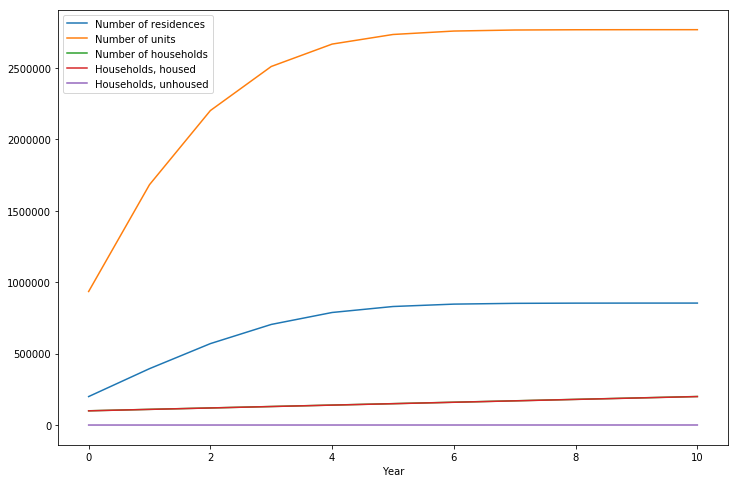

In [169]:
#Look at numbers of buildings and people by year
fig = plt.figure(figsize = (12, 8))
#plt.plot(hist.all_by_year['empty_land'], label = 'Land free for building')
plt.plot(hist.all_by_year['num_residences'], label = 'Number of residences')
plt.plot(hist.all_by_year['num_units'], label = 'Number of units')
plt.plot(hist.all_by_year['num_households'], label = 'Number of households')
plt.plot(hist.all_by_year['h_housed'], label = 'Households, housed')
plt.plot(hist.all_by_year['h_unhoused'], label = 'Households, unhoused')
plt.xlabel('Year')
plt.legend()
plt.show()

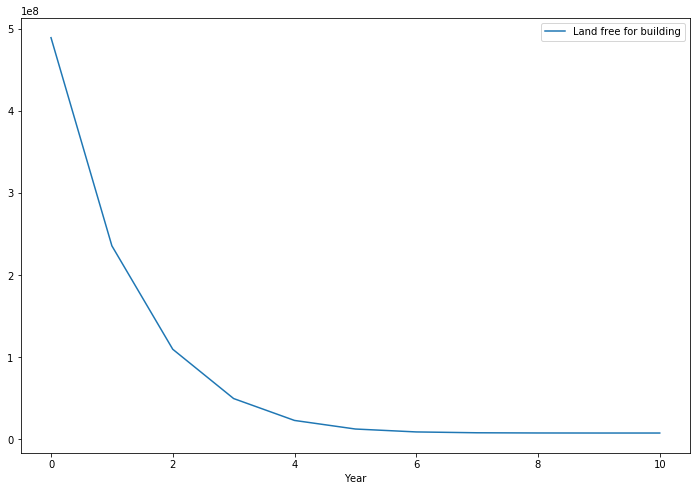

In [171]:
#Look at numbers of buildings and people by year
fig = plt.figure(figsize = (12, 8))
plt.plot(hist.all_by_year['empty_land'], label = 'Land free for building')
#plt.plot(hist.all_by_year['num_residences'], label = 'Number of residences')

plt.xlabel('Year')
plt.legend()
plt.show()

# VARIOUS CHECKS FOR OBJECTS IN SIM

In [ ]:
#For history object
#Test for lengths of these lists. They should all be equal length.
# print(len(residences_num))
# print(len(residence_size_avg))
# print(len(units_num))
# print(len(unit_size_avg))
# print(len(unit_value_avg))
# print(len(num_households))
# print(len(households_housed))
# print(len(households_unhoused))
# print(len(household_age_avg))
# print(len(household_has_avg))

In [ ]:
#This is the available area on one lot
#(sim.lots[0][0].size - sum([r.size for r in sim.lots[0][0].residences[0]]))

#Available area for all lots in one year
#[(l.size - sum([r.size for r in l.residences[0]])) \
#     for l in sim.lots[0]]

#Total area for one year vs avail area for one year
#total = sum([l.size  for l in sim.lots[0]])
#avail = sum([(l.size - sum([r.size for r in l.residences[0]])) \
     #for l in sim.lots[0]])

In [ ]:
#Check sizes of all lots
#sum([lot.size for lot in sim.lots[-1]])

In [ ]:
#Check size of each residence
#[residence.size for lot in sim.lots[-1] for residence in lot.residences[-1]]

In [ ]:
#Check size of each unit
#unit_sizes = [unit.value for lot in sim.lots[-1] for residence in lot.residences[-1] for unit in residence.units[-1]]

In [ ]:
len(unit_sizes)

In [ ]:
set(unit_sizes)

In [ ]:
plt.hist(unit_sizes, bins = 50)

In [ ]:
#Check area of each residence that isn't carved into units
#[(residence.size - sum(unit.size for unit in residence.units[-1])) for lot in sim.lots[-1] for residence in lot.residences[-1]]

In [ ]:
#Check unbuilt land of each lot
#avail_area = [lot.size - sum([residence.size for residence in lot.residences[-1]]) for lot in sim.lots[-1]]
#Avail area on each lot should be less than min_size for building a new residence
#avail_area

In [ ]:
#Check how many residences on each lot
#[len(lot.residences[-1]) for lot in sim.lots[-1]]

In [ ]:
#Check how many units in each residence
#[len(residence.units[-1]) for lot in sim.lots[-1] for residence in lot.residences[-1]]

In [ ]:
#Check a single lot
#vars(sim.lots[-1][0])

In [ ]:
#Check a single residence on a lot
#vars(sim.lots[-1][0].residences[-1][0])

In [ ]:
#Check a single unit in a residence
#vars(sim.lots[-1][0].residences[-1][0].units[-1][0])

In [ ]:
#THIS IS GREAT CODE DON'T DELETE
#Check all unit values
#How to quadruple nest a list comprehension:
#smallest for biggest in biggest for second biggest in second biggest for third biggest in third biggest
unit_values = [unit.value[-1] for lot in sim.lots[-1] for residence in lot.residences[-1] for unit in residence.units[-1]]
#unit_values
#plt.hist(unit_values)

In [ ]:
#Get total number of units in all residences on all lots
len([unit.value[-1] for lot in sim.lots[-1] for residence in lot.residences[-1] for unit in residence.units[-1]])

In [ ]:
#Check incomes for all households
#incomes = [household.has[-1] for household in sim.households[-1]]
#plt.hist(incomes)

In [ ]:
#Check incomes for currently housed households
#incomes_currently_housed = [household.has[-1] for household in sim.households[-1] if household.housed[-1]]
#plt.hist(incomes_currently_housed)

In [ ]:
#Check housing history for all households
#housing_history = [household.housed for household in sim.households[-1]]
#housing_history

In [58]:
uvals = [u.value[-1] for u in sim.units[-1] if not u.occ[-1]]

In [59]:
hhases = [h.has[-1] for h in sim.households[-1] if not h.housed[-1]]



In [60]:
np.array(uvals).min()


100.0

In [62]:
np.array(hhases).max()


98.72968617823653

In [ ]:
# #Test for instantiation of lots, residences built by developers, units per residence
# for lot in sim.lots[-1]:
#     print('Lot size:', lot.size)
#     print('Number of buildings on lot:', len(lot.residences[-1]))
#     for residence in lot.residences[-1]:
#         print('Building size:', residence.size)
#         print('Building zoned as:', residence.zoned_as)
#         print('Units in building:', len(residence.units[-1]))
#         print('Sqft per unit:', residence.size / len(residence.units[-1]))
#         for unit in residence.units[-1]:
#             print('Unit size:', unit.size)
#             print('Unit initial value:', unit.value[0])
#             print('Unit current value:', unit.value[-1])
#             print('Household size:', unit.occ[-1].size)
#             print('Household spending power:', unit.occ[-1].size)
#     print('\n')

In [ ]:
#CITY SETTINGS
#Size of land area in sqft (for now)
land = 1000000 #one trillion sqft in SF
num_lots = 1000 #800,000 in SF
lot_size_avg = 2000
lot_size_std = 500

#Starting population
pop_start = 1000
has_avg = 2000
has_std = 500

#Time and money
inflation = 0.02
years = 10

#Probability distribution of house sizes
#house_size_dist = np.random.normal(scale = house_size_std, loc = avg_house_size, size = households)


sim = Simulation(total_time_steps = years, 
                 land = land, 
                 num_lots = num_lots, 
                 lot_size_avg = lot_size_avg, 
                 lot_size_std = lot_size_std,
                 pop_start = pop_start, 
                 has_avg = has_avg, 
                 has_std = has_std, 
                 inflation = inflation,
                 )

# Viz: Assigning lots at start of sim (throws an error when top of grid is reached)

In [ ]:
#VIZ
def draw_land_grid(land):
    '''Writes a dict of y values, each with a dict of x values.
    Works as a grid of xes and yes.'''
    root = int(np.round(np.sqrt(land), 0) + 3)
    x_range = root
    y_range = root
    #Each point in the dict will get switched True when a house is drawn on it
    grid = {y: {x: False for x in np.arange(x_range)} for y in np.arange(y_range)}
    return grid

def assign_loc(lot, x, y, frontage):
    '''
    Assign a location to a lot.
    '''
    xes = np.arange(x, x + frontage)
    yes = np.arange(y, y + frontage)
    loc = [(x, y) for y in yes for x in xes]
    lot.loc = loc
    
def fill_coords(grid, loc):
    '''
    Fill the coords in the grid dict after assignment of previous lot.
    '''
    for coord in loc:
        #Reset the point to True in the dict of grid
        grid[coord[1]][coord[0]] = True

def avail(grid, x_, y_, frontage):
    #X adjusted to the left for padding
    x = x_ - 1
    #Y adjusted to the left for padding
    y = y_ - 1
    x_range = np.arange((x), (x + frontage + 2))
    y_range = np.arange((y), (y + frontage + 2))
    #List of bools returned from each point checked
    bottom = [grid[y][x_i] for x_i in x_range[:-1]]
    top = [grid[y + frontage][x_i] for x_i in x_range[1:]]
    left = [grid[y_i][x] for y_i in y_range[1:]]
    right = [grid[y_i][x + frontage] for y_i in y_range[:-1]]
    
    #Value of all bools
    points = sum(bottom) + sum(top) + sum(left) + sum(right)
    
    #If even one point in the proposed lot is taken (points != 0)
    if points:
        return False
    #If not a single point in the proposed lot is taken (points == 0)
    else:
        #print(x, y, 'is avail!')
        return True

#(Each row is a tuple of (x, bool))
def find_loc(grid, lot, next_x, next_y):
    '''
    #Traverse each row in the land grid via grid dict
    '''
    #Padding -1 right side
    x_range = len(grid[0]) - 1
    #Padding -1 top
    y_range = len(grid) - 1
    
    #One side of the square lot
    frontage = int(np.round(np.sqrt(lot.size), 0))
    
     #Traverse the y rows in the grid dict
    for y in np.arange(next_y, y_range):
        #If row isn't too full for this lot
        if x_range - sum([v for k, v in grid[y].items()]) > frontage:
            #print('Looking in row', y)
            #Traverse the row of x values
            for x in np.arange(next_x, x_range):
                #print('Looking in x', x)
                #If the right side of the lot is at the right edge of the grid, 
                #and at or below the top, continue
                if ((x + frontage) <= (x_range - 1)) and ((y + frontage) <= (y_range - 1)):
                    #If all frontage points in the proposed lot return False
                    if avail(grid, x, y, frontage):
                        #print('Assigning lot at', x, y)
                        #House gets assigned these coords
                        assign_loc(lot, x, y, frontage)
                        #Coords get changed to True in the grid dict
                        fill_coords(grid, lot.loc)
                        #Break the loop
                        #print('Found lot for ', lot.size)
                        #Return next x and next y to start on
                        #print((x + frontage), y)
                        return (x + frontage), y
        #If spot isn't found, reset x to 0 before moving up to next y
        #(Start at 1, not 0, for padding on left side)
        next_x = 1


In [ ]:
#Draw grid for sim
grid = draw_land_grid(land)

counter = 0
#Padding +1
next_x = 1
#Padding +1
next_y = 1

for _ in tqdm(range(len(sim.housing_stock))):
    #Draw a lot on the grid
    next_x, next_y = find_loc(grid, sim.housing_stock[_], next_x, next_y)
    #counter += 1
    #print(counter, 'out of', len(sim.housing_stock))

In [ ]:
#What does the grid look like?
grid[0]

In [ ]:
sim.housing_stock[10].sold

In [ ]:
sim.run()

# Visualizing lots (some overlap)

In [ ]:
#Draw viz of all lots
fig = plt.figure(figsize = (14,14))
for lot in sim.housing_stock:
    if lot.sold:
        color = 'blue'
    else:
        color = np.random.choice(['dimgray', 'darkgray', 'silver', 'slategray', 'powderblue', 'whitesmoke'])
    x = [point[0] for point in lot.loc]
    y = [point[1] for point in lot.loc]
    #ADD IF STATEMENT FOR SALE OF LOT
    plt.scatter(x, y, label = lot.size, marker = 's', color = color)
plt.show()

In [ ]:
#Draw viz of all lots
fig = plt.figure(figsize = (14,14))
for lot in sim.housing_stock:
    if lot.sold:
        color = 'blue'
    else:
        color = np.random.choice(['dimgray', 'darkgray', 'silver', 'slategray', 'powderblue', 'whitesmoke'])
    x = [point[0] for point in lot.loc]
    y = [point[1] for point in lot.loc]
    #ADD IF STATEMENT FOR SALE OF LOT
    plt.scatter(x, y, label = lot.size, marker = 's', color = color)
plt.show()